In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

## Power iteration

In [37]:
def poweriter(A, n_iter):
    gamma = []
    x = np.random.random((len(A),1))
    for _ in range(n_iter):
        y = A @ x
        norm_term = np.max(np.abs(y))
        m = np.argmax(np.abs(y))
        gamma.append((y[m]/x[m])[0])
        x = y / norm_term
    return gamma, x

A = np.random.random((5,5))
gamma, x = poweriter(A, 10)

print("power iteration:\n",gamma[-1])
print("\nnumpy solution:\n",np.linalg.eigvals(A)[0])


power iteration:
 2.2446682909767905

numpy solution:
 (2.2446682054060747+0j)


## Inverse iteration (shift inverse iteration)

In [3]:
def inviter(A, s, n_iter):
    gamma = []
    n = len(A)
    x = np.random.random((n,1))
    B = A - s*np.identity(n)
    P, L, U = scipy.linalg.lu(B)
    for _ in range(n_iter):
        y = np.linalg.lstsq(U,np.linalg.lstsq(L,x)[0])[0]
        norm_term = np.max(np.abs(y))
        m = np.argmax(np.abs(y))
        gamma.append((x[m]/y[m])[0]+s)
        x = y/norm_term
    return gamma, x

In [4]:
lambda_ = [1, -0.75, 0.6, -0.4, 0]
A = np.triu(np.ones(5),1) + np.diag(lambda_)

In [5]:
gamma, x = inviter(A, 0.7, 30)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [6]:
print("closet eigenvalue:", gamma[-1])

closet eigenvalue: 0.5999999999999982


## krylov subspaces

In [7]:
lambda_ = np.arange(1,101) + 10
A = np.diag(lambda_) + np.triu(np.random.random(100),1)
b = np.random.random((100,1))
print(A.shape)

(100, 100)


In [8]:
# let b as nature seed (u in text book)
Km = b
for m in range(29):
    v = A @ Km[:,m]
    Km = np.concatenate((Km, (v/np.linalg.norm(v)).reshape(100,1)), axis=1)
print(Km.shape)

(100, 30)


In [9]:
# solve a least square problem
resid = []
for m in range(30):
    z = np.linalg.lstsq((A@Km[:,:m+1]),b)[0]
    x = Km[:,0:m+1]@z
    resid.append(np.linalg.norm(b-A@x))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


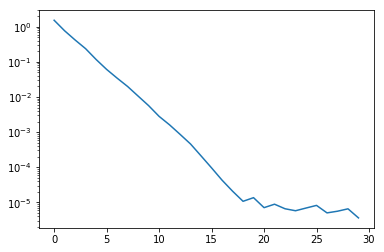

In [10]:
plt.plot(resid)
plt.yscale('log')
plt.show() 

In [11]:
z = np.linalg.lstsq((A@Km),b)[0]
x = Km @ z
np.linalg.norm(b- A@x)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


3.6060659534780062e-06

## The Arnoldi iteration

The Arnoldi iteration finds an **orthonormal** basis for a Krylov subspace

In [12]:
def arnoldi(A, u, m):
    n = len(A)
    Q = np.zeros((n,m+1))
    H = np.zeros((m+1, m))
    Q[:,0] = (u / np.linalg.norm(u)).flatten()
    for j in range(m):
        v = A @ Q[:,j]
        for i in range(j+1):
            H[i,j] = Q[:,i].T @ v
            v = v - H[i,j] * Q[:,i]
        # normalize
        H[j+1,j] = np.linalg.norm(v)
        Q[:,j+1] = v/H[j+1,j]
    return Q, H

# GMRES

In [13]:
# GMERS uses the output of the Arnoldi iteration to minimize the residual of Ax=b over successive K. space
lambda_ = np.arange(1,101) + 10
A = np.diag(lambda_) + np.triu(np.random.random(100),1)
b = np.random.random((100,1))
print(A.shape)

(100, 100)


In [14]:
Q, H = arnoldi(A,b,60)

$ x_{m} = Q_{m}z_{m} $

In [15]:
resid = []
for m in range(60):
    s = np.vstack((np.linalg.norm(b),np.zeros((m+1,1))))
    z = np.linalg.lstsq(H[:m+2,:m+1],s)[0]
    x = Q[:,:m+1] @ z
    error = np.linalg.norm(b-A@x)
    resid.append(error)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


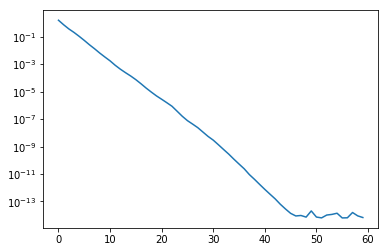

In [16]:
plt.plot(resid)
plt.yscale('log')
plt.show() 

In [32]:
# GMRES for a linear system 
def arngmres(A,b,M):
    # M: number of iteration
    n = len(A)
    Q = np.zeros((n,M+1))

    Q[:,0] = (b / np.linalg.norm(b)).flatten() # q1
    H = np.zeros((M+1,M))
    residual = []
    # set initional solution to zero
    for m in range(M):
        v = A @ Q[:,m]
        # next step of Arnoldi iteration
        for i in range(m+1):
            H[i,m] = Q[:,i].T @ v
            v = v - H[i,m] * Q[:,i]

        H[m+1,m] = np.linalg.norm(v)
        Q[:,m+1] = v / H[m+1,m]

        # solve the lstsq
        r = np.linalg.norm(b) * np.eye(m+2 ,1)
        z = np.linalg.lstsq(H[:m+2,:m+1], r)[0]
        x = Q[:,:m+1] @ z
        error =  np.linalg.norm(b-A@x)
        residual.append(error)
    return residual


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


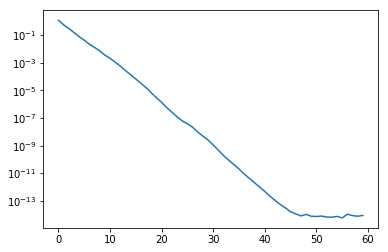

In [35]:
# GMERS uses the output of the Arnoldi iteration to minimize the residual of Ax=b over successive K. space
lambda_ = np.arange(1,101) + 10
A = np.diag(lambda_) + np.triu(np.random.random(100),1)
b = np.random.random((100,1))
resid = arngmres(A,b,60)
plt.plot(resid)
plt.yscale('log')
plt.show() 